# 9. Analyzing Training, Validation, and Testing Sets
Plotting some distributions of the test set.

In [1]:
import sys
import os
import h5py
from collections import Counter
from progressbar import *
import re
import numpy as np
from scipy import signal
import matplotlib
from repeating_classifier_training_utils import *
from functools import reduce

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

if par_dir not in sys.path:
    sys.path.append(par_dir)
%load_ext autoreload
%matplotlib inline
%autoreload 2

## Load test set

In [2]:
# Import test events from h5 file
filtered_index = "/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz"
filtered_indices = np.load(filtered_index, allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']

original_data_path = "/data/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5"
f = h5py.File(original_data_path, "r")

hdf5_event_data = (f["event_data"])
original_eventdata = np.memmap(original_data_path, mode="r", shape=hdf5_event_data.shape,
                                    offset=hdf5_event_data.id.get_offset(), dtype=hdf5_event_data.dtype)


original_energies = np.array(f['energies'])
original_positions = np.array(f['positions'])
original_angles = np.array(f['angles'])
original_labels = np.array(f['labels'])

# filtered_eventdata = original_eventdata[test_filtered_indices]
test_energies = original_energies[test_filtered_indices]
test_positions = original_positions[test_filtered_indices]
test_angles = original_angles[test_filtered_indices]
test_labels = original_labels[test_filtered_indices]
test_radius = [np.sqrt(test_positions[i,0,0]**2 + test_positions[i,0,2]**2) for i in range(test_positions.shape[0])]
f.close()

test_info = {'name':'Test Set','energies':test_energies,'positions':test_positions, 
             'angles':test_angles, 'labels':test_labels, 'radius':test_radius}

## Load Training/Validation Sets

In [3]:
trainval_data_path='/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M_splits_CNN/IWCDmPMT_4pi_fulltank_9M_trainval.h5'
trainval_idxs_path='/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M_splits_CNN/IWCDmPMT_4pi_fulltank_9M_trainval_idxs.npz'

idxs = np.load(trainval_idxs_path,allow_pickle=True)
train_idxs = idxs['train_idxs']
val_idxs = idxs['val_idxs']

f = h5py.File(trainval_data_path)
tv_hdf5_event_data = (f["event_data"])
tv_eventdata = np.memmap(trainval_data_path, mode="r", shape=tv_hdf5_event_data.shape,
                                    offset=tv_hdf5_event_data.id.get_offset(), dtype=tv_hdf5_event_data.dtype)

tv_energies = np.array(f['energies'])
tv_positions = np.array(f['positions'])
tv_angles = np.array(f['angles'])
tv_labels = np.array(f['labels'])

train_energies = tv_energies[train_idxs]
train_positions = tv_positions[train_idxs]
train_angles = tv_angles[train_idxs]
train_labels = tv_labels[train_idxs]
train_radius = [np.sqrt(train_positions[i,0,0]**2 + train_positions[i,0,2]**2) for i in range(train_positions.shape[0])]

train_info = {'name':'Training Set','energies':train_energies,'positions':train_positions, 
              'angles':train_angles, 'labels':train_labels, 'radius':train_radius}

val_energies = tv_energies[val_idxs]
val_positions = tv_positions[val_idxs]
val_angles = tv_angles[val_idxs]
val_labels = tv_labels[val_idxs]
val_radius = [np.sqrt(val_positions[i,0,0]**2 + val_positions[i,0,2]**2) for i in range(val_positions.shape[0])]

val_info = {'name':'Validation Set','energies':val_energies,'positions':val_positions, 
            'angles':val_angles, 'labels':val_labels, 'radius':val_radius}

/home/cmacdonald/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


In [4]:
dataset_info = [train_info,val_info,test_info]

## Distribution of event energies

In [50]:
GAMMA_THRESHOLD = 1.55
ELECTRON_THRESHOLD = 0.775
MUON_THRESHOLD = 160.26

In [51]:
shifted_energies = []
for idx in range(3):
    shifted_energies.append(np.zeros(dataset_info[idx]['labels'].shape[0]))
    g_idxs = np.where(dataset_info[idx]['labels']==0)[0]
    e_idxs = np.where(dataset_info[idx]['labels']==1)[0]
    m_idxs = np.where(dataset_info[idx]['labels']==2)[0]
    shifted_energies[idx][g_idxs] = np.squeeze(dataset_info[idx]['energies'][g_idxs] - GAMMA_THRESHOLD)
    shifted_energies[idx][e_idxs] = np.squeeze(dataset_info[idx]['energies'][e_idxs] - ELECTRON_THRESHOLD)
    shifted_energies[idx][m_idxs] = np.squeeze(dataset_info[idx]['energies'][m_idxs] - MUON_THRESHOLD)

<Figure size 432x288 with 0 Axes>

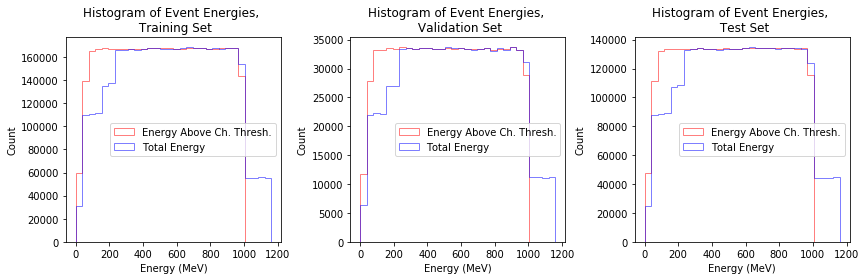

In [62]:
plt.figure()
fig,axes = plt.subplots(1,3,figsize=(12,4))
axes = axes.flatten()

for idx,ax in enumerate(axes[0:3]):
    ax.hist((np.squeeze(dataset_info[idx]['energies']),shifted_energies[idx]),bins=30,histtype=u'step',color=('b','r'),
            alpha = 0.5,label=['Total Energy','Energy Above Ch. Thresh.'])
    ax.set_title('Histogram of Event Energies, \n {}'.format(dataset_info[idx]['name']))
    ax.set_ylabel('Count')
    ax.set_xlabel('Energy (MeV)')
    ax.legend(loc='center right')
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

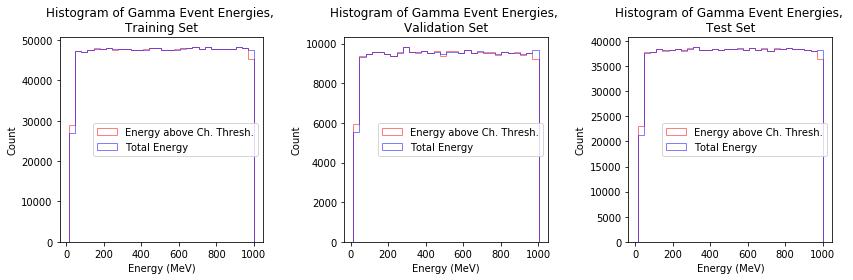

In [70]:
plt.figure()
fig,axes = plt.subplots(1,3,figsize=(12,4))
axes = axes.flatten()
for idx,ax in enumerate(axes[0:3]):
    g_idxs = np.where(dataset_info[idx]['labels']==0)[0]
    ax.hist((np.squeeze(dataset_info[idx]['energies'][g_idxs]),
             np.squeeze(dataset_info[idx]['energies'][g_idxs]- GAMMA_THRESHOLD)),bins=30,
            alpha=0.5,label=['Total Energy','Energy above Ch. Thresh.'],histtype=u'step',
             color=('b','r'))
    ax.set_title('Histogram of Gamma Event Energies, \n{}'.format(dataset_info[idx]['name']))
    ax.set_ylabel('Count')
    ax.set_xlabel('Energy (MeV)')
    ax.legend(loc='center right')
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

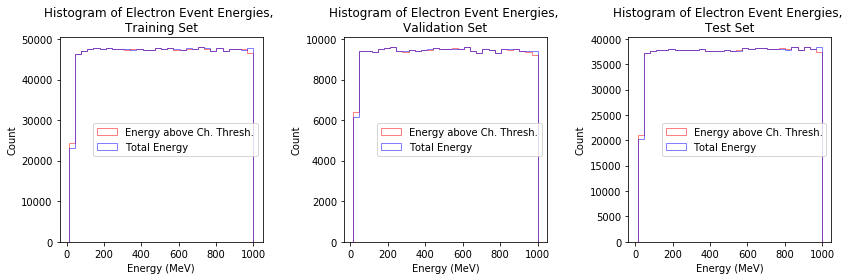

In [69]:
plt.figure()
fig,axes = plt.subplots(1,3,figsize=(12,4))
axes = axes.flatten()
for idx,ax in enumerate(axes[0:3]):
    e_idxs = np.where(dataset_info[idx]['labels']==1)[0]
    ax.hist((np.squeeze(dataset_info[idx]['energies'][e_idxs]),
             np.squeeze(dataset_info[idx]['energies'][e_idxs]- ELECTRON_THRESHOLD)),bins=30,
            alpha=0.5,label=['Total Energy','Energy above Ch. Thresh.'],histtype=u'step',
             color=('b','r'))
    ax.set_title('Histogram of Electron Event Energies, \n{}'.format(dataset_info[idx]['name']))
    ax.set_ylabel('Count')
    ax.set_xlabel('Energy (MeV)')
    ax.legend(loc='center right')
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

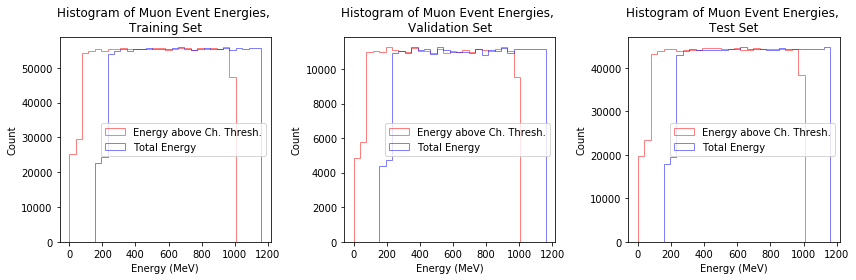

In [71]:
plt.figure()
fig,axes = plt.subplots(1,3,figsize=(12,4))
axes = axes.flatten()
for idx,ax in enumerate(axes[0:3]):
    m_idxs = np.where(dataset_info[idx]['labels']==2)[0]
    ax.hist((np.squeeze(dataset_info[idx]['energies'][m_idxs]),
             np.squeeze(dataset_info[idx]['energies'][m_idxs]- MUON_THRESHOLD)),bins=30,
            alpha=0.5,label=['Total Energy','Energy above Ch. Thresh.'],histtype=u'step',
             color=('b','r'))
    ax.set_title('Histogram of Muon Event Energies, \n{}'.format(dataset_info[idx]['name']))
    ax.set_ylabel('Count')
    ax.set_xlabel('Energy (MeV)')
    ax.legend(loc='center right')
plt.tight_layout()
plt.show()

## Distribution of total charge

In [5]:
total_charge = []

pbar = ProgressBar(widgets=['Calculating Total Charge for Training Set. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=len(train_idxs))
pbar.start()
for i in range(len(train_idxs)):
    pbar.update(i)
    total_charge.append(np.sum(tv_eventdata[train_idxs[i]]))
pbar.finish()
dataset_info[0]['total_charge'] = total_charge

Calculating Total Charge for Training Set. Progress: 100% [00000] Time: 0:46:23


In [17]:
np.savez('training_set_total_charge.npz',total_charge=dataset_info[0]['total_charge'])

In [5]:
dataset_info[0]['total_charge'] = np.load('training_set_total_charge.npz',allow_pickle=True)['total_charge']

In [7]:
total_charge = []

pbar = ProgressBar(widgets=['Calculating Total Charge for Validation Set. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=len(val_idxs))
pbar.start()
for i in range(len(val_idxs)):
    pbar.update(i)
    total_charge.append(np.sum(tv_eventdata[val_idxs[i]]))
pbar.finish()
dataset_info[1]['total_charge'] = total_charge

Calculating Total Charge for Validation Set. Progress: 100% [000] Time: 0:09:30


In [18]:
np.savez('validation_set_total_charge.npz',total_charge=dataset_info[1]['total_charge'])

In [6]:
dataset_info[1]['total_charge'] = np.load('validation_set_total_charge.npz',allow_pickle=True)['total_charge']

<Figure size 432x288 with 0 Axes>

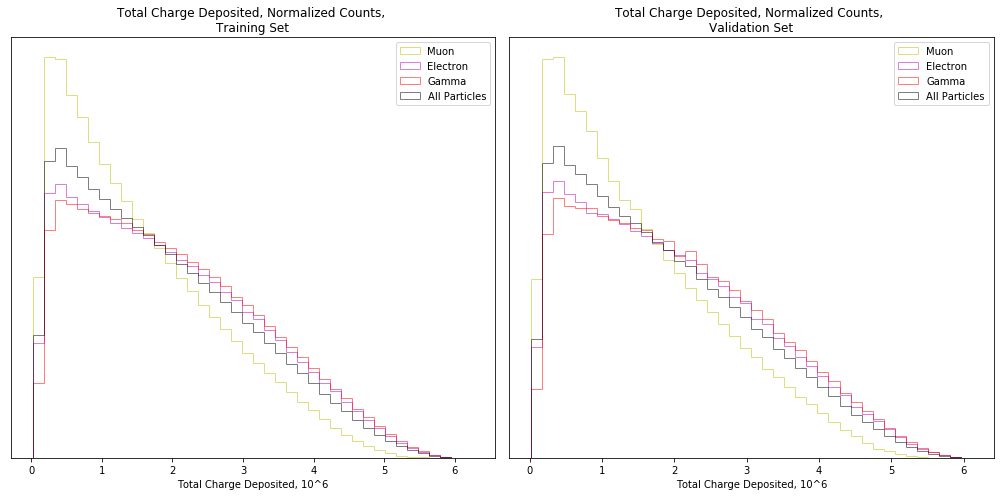

In [72]:
plt.figure()
fig,axes = plt.subplots(1,2,figsize=(14,7))
axes = axes.flatten()
N_BINS = 40
for i,ax in enumerate(axes):
    num_events=len(dataset_info[i]['total_charge'])
    g_idxs = np.where(dataset_info[i]['labels']==0)[0]
    e_idxs = np.where(dataset_info[i]['labels']==1)[0]
    m_idxs = np.where(dataset_info[i]['labels']==2)[0]
    _,_,patches = ax.hist((dataset_info[i]['total_charge']/10**6,
                           dataset_info[i]['total_charge'][g_idxs]/10**6,
                           dataset_info[i]['total_charge'][e_idxs]/10**6,
                           dataset_info[i]['total_charge'][m_idxs]/10**6),
                           weights=(np.ones(num_events),np.ones(len(g_idxs))*num_events/len(g_idxs),
                                    np.ones(len(e_idxs))*num_events/len(e_idxs),np.ones(len(m_idxs))*num_events/len(m_idxs)),
                           bins=N_BINS, color = ('k','r','m','y'), alpha = 0.5,
                           label=['All Particles', 'Gamma','Electron','Muon'],histtype=u'step')
    
    ax.set_title('Total Charge Deposited, Normalized Counts, \n{}'.format(dataset_info[i]['name']))
    ax.set_ylabel('Count')
    ax.set_xlabel('Total Charge Deposited, 10^6')
    ax.axes.get_yaxis().set_visible(False)
    ax.legend()
plt.savefig('overlayed.png')
plt.tight_layout()
plt.show()

In [ ]:
total_charge = []

pbar = ProgressBar(widgets=['Calculating Total Charge for Testing Set. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=len(test_filtered_indices))
pbar.start()
for i in range(len(test_filtered_indices)):
    pbar.update(i)
    total_charge.append(np.sum(original_eventdata[test_filtered_indices[i]]))
pbar.finish()
dataset_info[2]['total_charge'] = total_charge

## Distribution of event departure angles

In [ ]:
plt.figure()
fig,ax = plt.subplots(1,1,figsize=(12,6))

ax.hist(([data['angles'][:,0] for data in dataset_info]),bins=30,histtype=u'step', label=[data['name'] for data in dataset_info],
       alpha = 0.5, color=('b','r','m'),weights=([np.ones(data['angles'].shape[0])*1/data['angles'].shape[0] for data in dataset_info]))
ax.set_title('Histogram of Event Polar Angles, Normalized Count')
ax.set_ylabel('Count')
ax.set_xlabel('Polar Angle (rad)')
ax.axes.get_yaxis().set_visible(False)
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure()
fig,ax = plt.subplots(1,1,figsize=(12,6))

ax.hist(([data['angles'][:,1] for data in dataset_info]),bins=30,histtype=u'step', label=[data['name'] for data in dataset_info],
       alpha = 0.5, color=('b','r','m'),weights=([np.ones(data['angles'].shape[0])*1/data['angles'].shape[0] for data in dataset_info]))
ax.set_title('Histogram of Event Azimuthal Angles, Normalized Count')
ax.set_ylabel('Count')
ax.set_xlabel('Azimuthal Angle (rad)')
ax.axes.get_yaxis().set_visible(False)
ax.legend(loc='center right')
plt.tight_layout()
plt.show()

## Distribution of events throughout the detector volume

<Figure size 432x288 with 0 Axes>

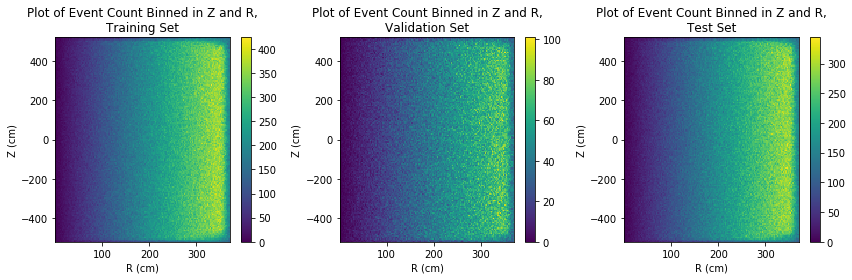

In [49]:
plt.figure()
fig,axes = plt.subplots(1,3,figsize=(12,4))
for idx,ax in enumerate(axes):
    mat,_,_,im = ax.hist2d(dataset_info[idx]['radius'], dataset_info[idx]['positions'][:,0,1],[150,150])
#     cbar = ax.colorbar(im)
    fig.colorbar(im,ax=ax)
    ax.set_title('Event Count Binned in Z and R,\n{}'.format(dataset_info[idx]['name']))
    ax.set_ylabel('Z (cm)')
    ax.set_xlabel('R (cm)')
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

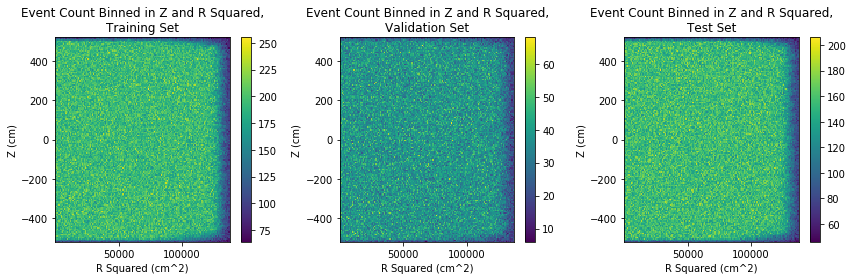

In [51]:
plt.figure()
fig,axes = plt.subplots(1,3,figsize=(12,4))
for idx,ax in enumerate(axes):
    mat,_,_,im = ax.hist2d(list(map(lambda x : x**2,dataset_info[idx]['radius'])), dataset_info[idx]['positions'][:,0,1],[150,150])
#     cbar = ax.colorbar(im)
    fig.colorbar(im,ax=ax)
    ax.set_title('Event Count Binned in Z and R Squared,\n{}'.format(dataset_info[idx]['name']))
    ax.set_ylabel('Z (cm)')
    ax.set_xlabel('R Squared (cm^2)')
plt.tight_layout()
plt.show()

## Display some randomly selected test event data from edge events

In [57]:
border_event_idxs = []
i = 0
search_idxs = np.random.permutation(len(test_radius))
while len(border_event_idxs) < 3:
    if test_radius[search_idxs[i]] > 360:
        border_event_idxs.append(search_idxs[i])
    i+=1

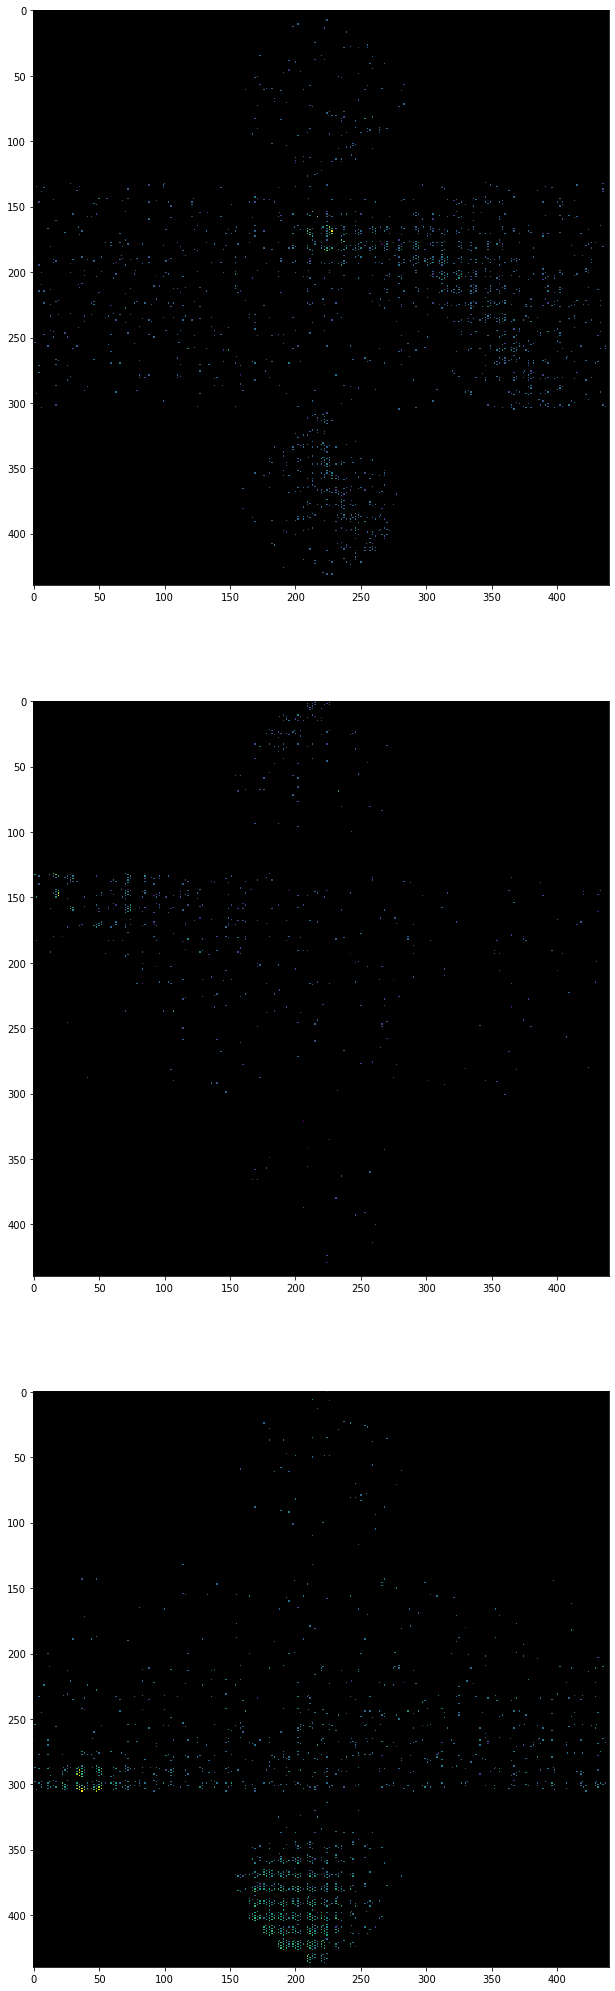

In [58]:
from utils.plot_utils import get_plot_array
fig, axes = plt.subplots(3,1,figsize=(18,12*3),facecolor='w')
axes = axes.flatten()
cmap = plt.cm.viridis
cmap.set_bad(color='black')
for idx in range(len(axes)):
    ax = axes[idx]
    a=get_plot_array(original_eventdata[test_filtered_indices[border_event_idxs[idx]],:,:,0:19])
    a = np.ma.masked_where(a < 0.05, a)
    ax.imshow(a,
               origin="upper",
               cmap=cmap,
               norm=matplotlib.colors.LogNorm(vmax=np.amax(a),
                                             clip=True))
plt.show()

## Display some randomly selected test event data from middle-of-tank events

In [59]:
middle_event_idxs = []
i = 0
search_idxs = np.random.permutation(len(test_radius))
while len(middle_event_idxs) < 3:
    if test_radius[search_idxs[i]] < 50 and np.pi/4 < test_angles[i][0] < 3/4*np.pi:
        middle_event_idxs.append(search_idxs[i])
    i+=1

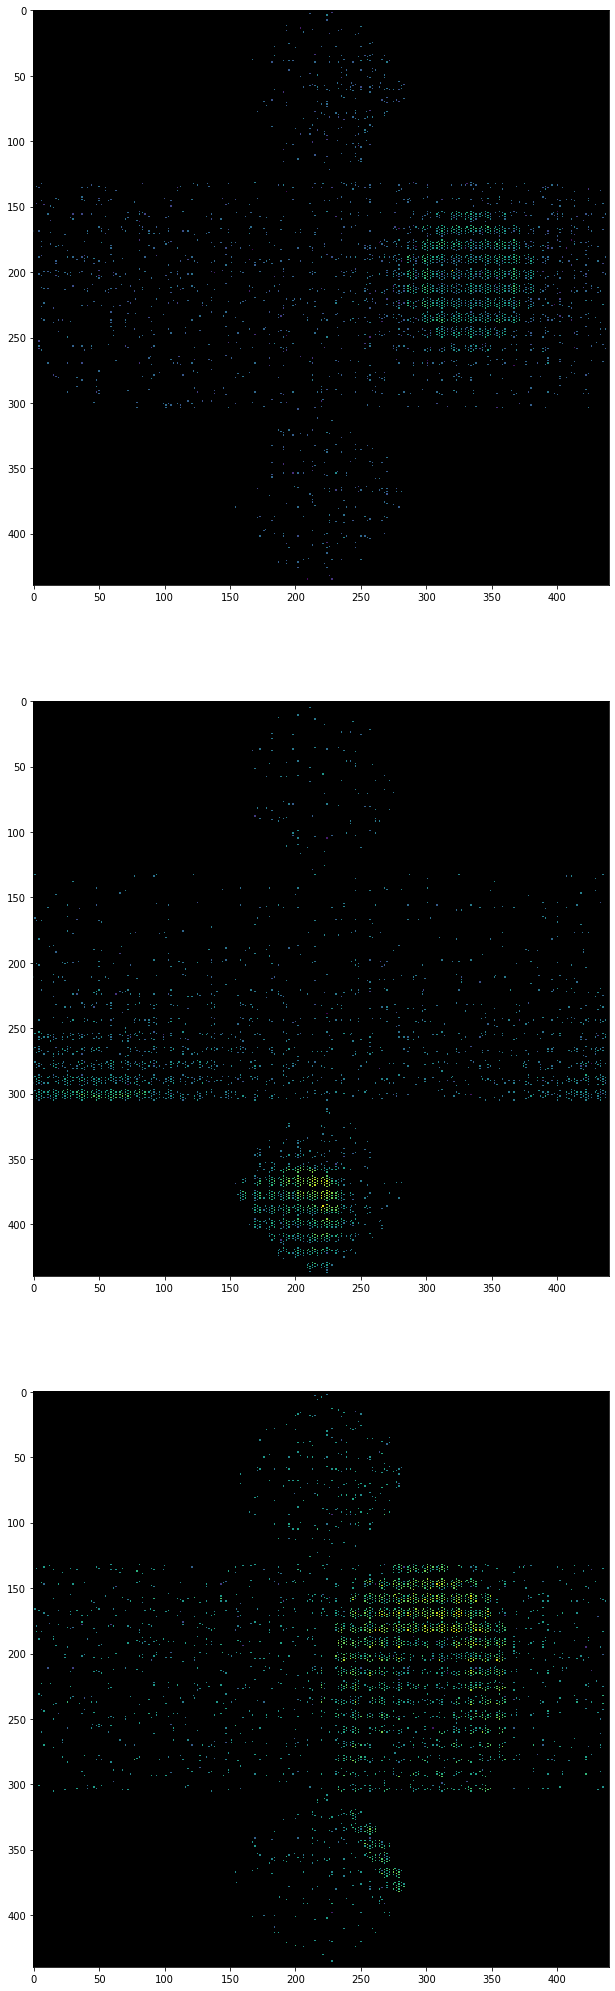

In [60]:
from utils.plot_utils import get_plot_array
fig, axes = plt.subplots(3,1,figsize=(18,12*3),facecolor='w')
axes = axes.flatten()
cmap = plt.cm.viridis
cmap.set_bad(color='black')
for idx in range(len(axes)):
    ax = axes[idx]
    a=get_plot_array(original_eventdata[test_filtered_indices[middle_event_idxs[idx]],:,:,0:19])
    a = np.ma.masked_where(a < 0.05, a)
    ax.imshow(a,
               origin="upper",
               cmap=cmap,
               norm=matplotlib.colors.LogNorm(vmax=np.amax(a),
                                             clip=True))
plt.show()

## Distribution of distance to wall along particle trajectory

In [84]:
pbar = ProgressBar(widgets=['Calculating Distance to Wall. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=reduce(lambda x,y:x+y , list(map(lambda x : x['positions'].shape[0], dataset_info))))
pbar.start()
done=0
for dset in dataset_info:
    d_to_wall = []
    for i in range(dset['positions'].shape[0]):
        pbar.update(done + i)
        d_to_wall.append(distance_to_wall(dset['positions'][i][0],dset['angles'][i]))
        dset['d_to_wall']=d_to_wall
    done = done + dset['positions'].shape[0]
pbar.finish()

Calculating Distance to Wall. Progress: 100% [000000000000000000] Time: 0:12:51


<Figure size 432x288 with 0 Axes>

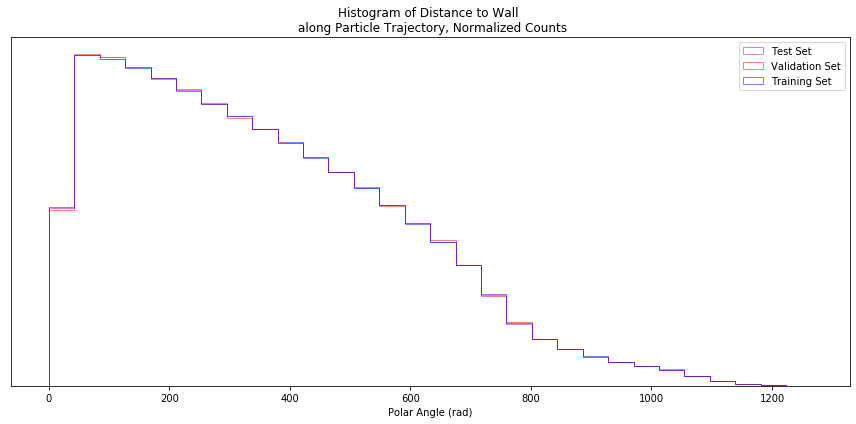

In [88]:
plt.figure()
fig,ax = plt.subplots(1,1,figsize=(12,6))

ax.hist(([data['d_to_wall'] for data in dataset_info]),bins=30,histtype=u'step', label=[data['name'] for data in dataset_info],
       alpha = 0.5, color=('b','r','m'),weights=([np.ones(len(data['d_to_wall']))*1/len(data['d_to_wall']) for data in dataset_info]))
ax.set_title('Histogram of Distance to Wall \n along Particle Trajectory, Normalized Counts')
ax.set_ylabel('Count')
ax.set_xlabel('Polar Angle (rad)')
ax.axes.get_yaxis().set_visible(False)
ax.legend()
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

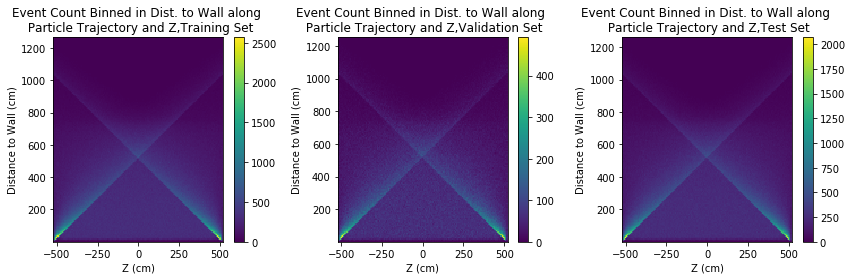

In [74]:
plt.figure()
fig,axes = plt.subplots(1,3,figsize=(12,4))
for idx,ax in enumerate(axes):
    mat,_,_,im = ax.hist2d(dataset_info[idx]['positions'][:,0,1], dataset_info[idx]['d_to_wall'],[150,150])
#     cbar = ax.colorbar(im)
    fig.colorbar(im,ax=ax)
    ax.set_title('Event Count Binned in Dist. to Wall along \n Particle Trajectory and Z, {}'.format(dataset_info[idx]['name']))
    ax.set_xlabel('Z (cm)')
    ax.set_ylabel('Distance to Wall (cm)')
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

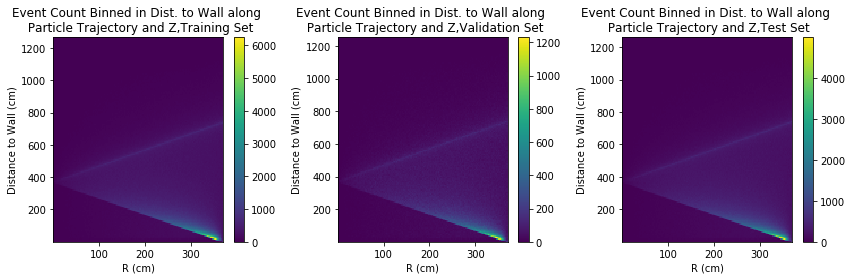

In [75]:
plt.figure()
fig,axes = plt.subplots(1,3,figsize=(12,4))
for idx,ax in enumerate(axes):
    mat,_,_,im = ax.hist2d(dataset_info[idx]['radius'], dataset_info[idx]['d_to_wall'],[150,150])
#     cbar = ax.colorbar(im)
    fig.colorbar(im,ax=ax)
    ax.set_title('Event Count Binned in Dist. to Wall along \n Particle Trajectory and Z, {}'.format(dataset_info[idx]['name']))
    ax.set_xlabel('R (cm)')
    ax.set_ylabel('Distance to Wall (cm)')
plt.tight_layout()
plt.show()